<a id="top"></a>
# LUVex Aperture Generation Notebook

This notebook is used to generate hexagonal segmented apertures. 


## Package imports

In [1]:
#%matplotlib qt
import os
os.chdir('../..')
%matplotlib inline
from hcipy import *
from aplc_optimization.Inputs_Generation.SCDA_Inputs_Generation import make_SCDA_hex_aperture
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import math

## Defining functions

Aperture generation function catered to the LUVex test apertures:

In [90]:
def make_LUVex_test_aperture(normalized=True, with_spiders=False, with_obstruction=False, clipped=True,
                           with_segment_gaps=False, gap_padding=0, num_rings=6, segment_transmissions=1,
                           return_header=False, return_segments=False, pupil_diameter=7.9445, pupil_inscribed = 6.0023):
    num_segments = 3 * num_rings * (num_rings + 1) #including the central segment
    actual_segment_gap = 0.006 #m gap size between segments
    segment_gap = actual_segment_gap * gap_padding  # padding out the segmentation gaps so they are visible and not sub-pixel
    
    if not with_segment_gaps:
        segment_gap = 0
    
    actual_pupil_diameter = pupil_diameter
    
    if clipped and num_rings > 2: 
        num_segments = num_segments-6  #subtract the 6 ommitted corner segments
        actual_segment_flat_diameter = (pupil_inscribed - 2*(num_rings-1)*segment_gap) / (2*(num_rings-1)+1)
        pupil_diameter = actual_segment_flat_diameter * (2*(num_rings)+1) + 2*(num_rings)*segment_gap
    else:
        actual_segment_flat_diameter = (pupil_diameter - 2*num_rings*segment_gap) / (2*num_rings+1)
    
    segment_flat_diameter = actual_segment_flat_diameter - (segment_gap - actual_segment_gap)

    segment_circum_diameter = 2 / np.sqrt(3) * segment_flat_diameter  # segment circumscribed diameter
    
    aperture_header = {'TELESCOP': 'SCDA', 'D_CIRC': actual_pupil_diameter, 'D_INSC': pupil_inscribed,
                        'SEG_F2F_D': actual_segment_flat_diameter, 'SEG_GAP': actual_segment_gap, 'GAP_PAD':gap_padding,
                        'NORM': normalized, 'SEG_TRAN': segment_transmissions, 
                        'NUM_RINGS': num_rings, 'CLIPPED': clipped, 'NUM_SEG': num_segments}

    if normalized:
        segment_circum_diameter /= pupil_diameter
        segment_flat_diameter /= pupil_diameter
        segment_gap /= pupil_diameter
        pupil_diameter = 1.0

    segment_positions = make_hexagonal_grid(segment_flat_diameter + segment_gap, num_rings)

    # clipping the "corner" segments of the outermost rings
    # clipping the corner segments maximizes the telescope geometry to render it as circular as possible
    # and maximizes the diameter of the inscribed circle with respect to the overall diameter.
    if clipped:
        segment_positions = segment_positions.subset(circular_aperture(pupil_diameter * 0.85))

    segment = hexagonal_aperture(segment_circum_diameter, np.pi / 2)

    segmented_aperture = make_segmented_aperture(segment, segment_positions, segment_transmissions,
                                                 return_segments=return_segments)

    if return_segments:
        segmented_aperture, segments = segmented_aperture

    def func(grid):
        res = segmented_aperture(grid)

        return Field(res, grid)

    if return_header:
        if return_segments:
            return func, aperture_header, segments
        else:
            return func, aperture_header
    elif return_segments:
        return func, segments
    else:
        return


Function generate a Lyot stop slightly undersized to the inscribed pupil diameter.

In [391]:
def make_a_lyot_stop(normalized=False, inner_diameter_fraction=0.2, outer_diameter_fraction=0.9, 
                     return_header=False, pupil_diameter=7.9445, pupil_inscribed = 6.0023):

    outer_D = pupil_inscribed * outer_diameter_fraction
    inner_D = pupil_inscribed * inner_diameter_fraction

    lyot_reference_diameter = pupil_inscribed

    ls_header = {'TELESCOP':'LUVOIR A', 'D_CIRC': pupil_diameter, 'D_INSC': pupil_inscribed,
                 'LS_ID': inner_diameter_fraction, 'LS_OD': outer_diameter_fraction, 
                 'LS_REF_D': lyot_reference_diameter, 'NORM': normalized}
    

    if normalized:
        outer_D /= pupil_diameter
        inner_D /= pupil_diameter
        
    outer_diameter = circular_aperture(outer_D)
    central_obscuration = circular_aperture(inner_D)

    def aper(grid):
        result = outer_diameter(grid) - central_obscuration(grid)

        return result

    if return_header:
        return aper, ls_header

    return aper

## Parameters

In [392]:
filepath = 'masks/SCDA/'
N        = 1024  #Number of pixels in aperture, lyot stop, apodizer array
oversamp = 4    #oversampling factor in evaluate_supersampled [hcipy/field/util.py]. 
                #If set to 1 returns bw pupil. For gray set to > 1, nominally set to 4 (4 grey levels)
gap_padding = 1

In [393]:
num_rings = 1 #number of rings of hexagons N around the central segment

Circumscribed and inscribed pupil diameters based on the pupil files provided by Rosey. 

In [378]:
pup_diams = [[7.9445, 6.0023],  # Hex-1
             [7.2617, 5.9994],  # Hex-2
             [7.7231, 5.9899],  # Hex-3
             [7.1522, 5.9937],  # Hex-4
             [6.8526, 5.9941]]  # Hex-5

#Get the corresponding diameters from the number of rings.
pupil_diameter, pupil_diameter_inscribed = pup_diams[num_rings-1] 

### Aperture parameters
Segmented pupil composed of hexagonal segments distributed over `num_rings` rings around the central
segment. 

In [394]:
#oversampling factor, black and white or grey pixels
if oversamp == 1:
    edge = 'bw'
elif oversamp > 1:
    edge = 'gy'

The 'clipped' flag, allows for the outer corner segments of the pupil to me omitted, to maximize the telescope geometry to render it as circular as possible and maximizing the diameter of the inscribed circle with respect to the overall diameter.

In [395]:
clipped = False              #whether to omit outer segments to form a more circular aperture

num_segments = 3*num_rings*(num_rings+1)+1
if clipped:
    num_segments = num_segments-6

print('Segmented pupil composed of {0} hexagonal segments distributed over {1} rings around the central segment.'.format(num_segments, num_rings))

Segmented pupil composed of 7 hexagonal segments distributed over 1 rings around the central segment.


### Lyot Stop parameters

In [382]:
lyot_ref_diam            = pupil_diameter_inscribed #diameter used to reference LS id and od against

Setting the Lyot stop inner diameter to 0 to remove central obstruction.

In [396]:
LS_ID = [0]     #lyot stop inner diameter(s), relative to inscribed circle, 
                #re-normalized against circumscribed pupil in LS gen function
    
LS_OD = [0.982] #lyot stop outer diameter, relative to inscribed circle, 
                #re-normalized against circumscribed pupil in LS gen function

### Filepath and Filenames

### Construct aperture, write to fits

In [384]:
if clipped:
    pup_filename = 'TelAp_LUVex_{0:02d}-Hex_{1:s}_clipped_ovsamp{2:02d}__N{3:04d}.fits'.format(num_rings,edge,oversamp,N)
else:
    pup_filename = 'TelAp_LUVex_{0:02d}-Hex_{1:s}_ovsamp{2:02d}__N{3:04d}.fits'.format(num_rings,edge,oversamp,N)

grid                     = make_pupil_grid(N)
HEX_ap, aperture_header  = make_LUVex_test_aperture(normalized=True, clipped = True, num_rings=num_rings, 
                                                    return_header = True, gap_padding=gap_padding, 
                                                    with_segment_gaps=True,
                                                    pupil_diameter=pupil_diameter, 
                                                    pupil_inscribed=pupil_diameter_inscribed)
pupil                       = evaluate_supersampled(HEX_ap,grid,oversamp)

aperture_header['OVERSAMP'] = oversamp
aperture_header['EDGE']     = edge
aperture_header['D_INSC']   = pupil_diameter_inscribed
hdr = fits.Header()
hdr.set('TELESCOP', aperture_header['TELESCOP'])
hdr.set('D_CIRC', aperture_header['D_CIRC'],'m: circumscribed diameter')
hdr.set('D_INSC', aperture_header['D_INSC'],'m: inscribed diameter')
hdr.set('SEG_F2F',aperture_header['SEG_F2F_D'],'m: actual segment flat-to-flat diameter')
hdr.set('SEG_GAP',aperture_header['SEG_GAP'],'m: actual gap size between segments')
hdr.set('NORM',aperture_header['NORM'],'normalization keyword, OD scaled to 1 by Dcirc')
hdr.set('NUM_RINGS',aperture_header['NUM_RINGS'], 'number of rings of hexagons')
hdr.set('SEG_TRAN',aperture_header['SEG_TRAN'],'transmission for each of the segments')
#hdr.set('NUM_SEG',aperture_header['NUM_SEG'],'number of hexagonal segments')
hdr.set('EDGE',aperture_header['EDGE'],'black and white, or grey pixels')
hdr.set('OVERSAMP',aperture_header['OVERSAMP'],'oversampling factor, # grey levels')

fits.writeto(filepath+pup_filename, pupil.shaped, hdr,overwrite=True)
print(filepath+pup_filename)


masks/SCDA/TelAp_LUVex_01-Hex_gy_ovsamp04__N1024.fits


## 

### Construct lyot stop(s), write to fits

Using knowledge of inscribed circle diameter, we can calculate the pupil diameter prior to corner segment clipping that is needed for the Lyot stop generation.

In [385]:
if clipped and num_rings > 2:
    actual_segment_gap = 0.006
    segment_gap = actual_segment_gap * gap_padding 
    actual_segment_flat_diameter = (pupil_diameter_inscribed - 2*(num_rings-1)*segment_gap) / (2*(num_rings-1)+1)
    pupil_diameter = actual_segment_flat_diameter * (2*(num_rings)+1) + 2*(num_rings)*segment_gap
    

In [386]:
for ls_id in LS_ID:
    for ls_od in LS_OD:
        
        strut_key = 'no_struts'
        ls_filename  = 'LS_LUVex_{0:02d}-Hex_ID{1:04d}_OD{2:04d}_{3:s}_{4:s}_ovsamp{5:d}_N{6:04d}.fits'.format(num_rings, int(ls_id*1000), \
                                                                                                int(ls_od*1000), \
                                                                                                strut_key, edge, \
                                                                                                oversamp, N)

        LUVOIR_ls,ls_header = make_a_lyot_stop(normalized=True, inner_diameter_fraction=ls_id, 
                                               outer_diameter_fraction=ls_od, return_header=True, 
                                               pupil_diameter=pupil_diameter, pupil_inscribed=pupil_diameter_inscribed)
        lyot_stop = evaluate_supersampled(LUVOIR_ls, grid, oversamp)
    
        hdr = fits.Header()
        ls_header['OVERSAMP'] = oversamp
        ls_header['EDGE']     = edge
        ls_header['D_INSC']   = pupil_diameter_inscribed
    
        hdr = fits.Header()
        hdr.set('TELESCOP', ls_header['TELESCOP'])
        hdr.set('D_CIRC', ls_header['D_CIRC'],'m: circumscribed diameter')
        hdr.set('D_INSC', ls_header['D_INSC'],'m: inscribed diameter')
        hdr.set('LS_REF_D',ls_header['LS_REF_D'],'m: used to reference given LS id and od')
    
        hdr.set('LS_ID', ls_header['LS_ID'], 'LS inner d, fraction of LS_REF_D')
        hdr.set('LS_OD', ls_header['LS_OD'], 'LS outer d, fraction of LS_REF_D')
    
        hdr.set('NORM',ls_header['NORM'],'normalization keyword, OD scaled to 1 by Dcirc')
        hdr.set('EDGE',ls_header['EDGE'],'black and white, or grey pixels')
        hdr.set('OVERSAMP',ls_header['OVERSAMP'],'oversampling factor, # grey levels')
    
        fits.writeto(filepath+ls_filename, lyot_stop.shaped, hdr, overwrite=True)
    
print(filepath+ls_filename)


masks/SCDA/LS_LUVex_01-Hex_ID0000_OD0982_no_struts_gy_ovsamp4_N1024.fits


### Plot aperture and lyot stop

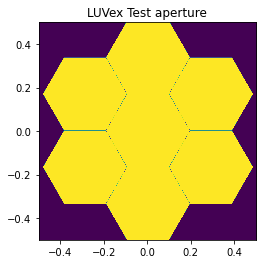

In [398]:
plt.figure()
plt.title('LUVex Test aperture')
imshow_field(pupil)
plt.show()

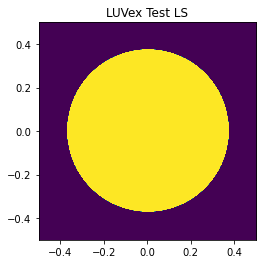

In [399]:
plt.figure()
plt.title('LUVex Test LS')
imshow_field(lyot_stop)
plt.show()

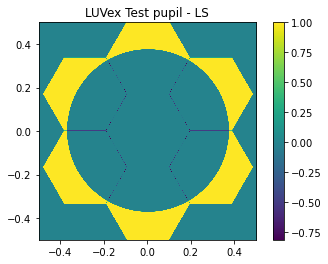

In [400]:
plt.figure()
plt.title('LUVex Test pupil - LS')
imshow_field(pupil-lyot_stop)
plt.colorbar()
plt.show()

[Top of page](#top)